In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('twitter_sentiment_data.csv')
df

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
...,...,...,...
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,1,What will your respective parties do to preven...,791316857403936768
43940,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,791357509101621249
43941,0,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


> Remove tweets of class News

In [3]:
df.drop(df[df['sentiment'] == 2].index, inplace = True)
df = df.reset_index()
df = df.drop('index', 1)

In [4]:
#for col in df.columns:
#    print(col)

In [5]:
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,0,Unamshow awache kujinga na iko global warming ...,793125429418815489


In [6]:
df.sentiment.unique()

array([-1,  1,  0])

In [7]:
from copy import deepcopy
df2 = deepcopy(df)

In [8]:
labels = df.sentiment.unique()

> **Classes:**
> - 2(News): the tweet links to factual news about climate change (This Class values are removed)
> - 1(Pro): the tweet supports the belief of man-made climate change
> - 0(Neutral: the tweet neither supports nor refutes the belief of man-made climate change
> -  -1(Anti): the tweet does not believe in man-made climate change

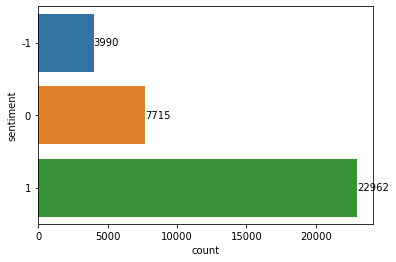

In [9]:
count_plot = sns.countplot(data = df,
                           y = 'sentiment')
count_plot.bar_label(count_plot.containers[0])
plt.show()

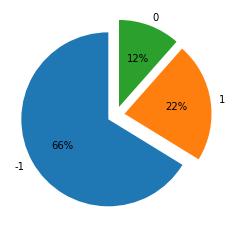

In [10]:
plt.pie(df["sentiment"].value_counts(),
        labels=labels,
        autopct="%1.0f%%",
        startangle=90,
        explode=tuple([0.1] * len(labels)))
plt.show()

In [11]:
count = df.sentiment.value_counts()
count.name = "Count"

percent = df.sentiment.value_counts(normalize=True)
percent.name = "Percentage"

display(pd.concat([count, percent], axis=1))

,Count,Percentage
1,22962,0.662359
0,7715,0.222546
-1,3990,0.115095


In [12]:
df_pro = df[df.sentiment == 1]
df_neutral = df[df.sentiment == 0]
df_anti = df[df.sentiment == -1]
#df_news = df[df.sentiment == 2]

In [13]:
#df_pro.head()

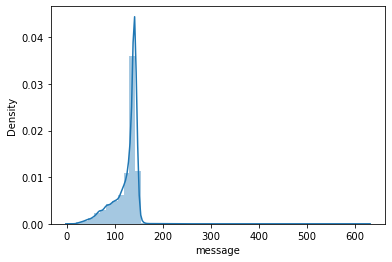

In [14]:
sns.distplot(df.message.str.len())

plt.show()

In [15]:
df.message.str.len().describe()

count    34667.000000
mean       123.693368
std         25.847211
min          7.000000
25%        114.000000
50%        135.000000
75%        140.000000
max        623.000000
Name: message, dtype: float64

In [16]:
import re
import nltk
import itertools
from tqdm.auto import tqdm

In [17]:
top20 = {}


for sentiment, group in df.groupby("sentiment"):
    hashtags = group["message"].apply(lambda tweet: re.findall(r"#(\w+)", tweet))
    hashtags = itertools.chain(*hashtags)
    hashtags = [ht.lower() for ht in hashtags]
    
    frequency = nltk.FreqDist(hashtags)
    
    df_hashtags = pd.DataFrame({
        "hashtags": list(frequency.keys()),
        "counts": list(frequency.values()),
    })
    top20_htags = df_hashtags.nlargest(20, columns=["counts"])
    
    top20[sentiment] = top20_htags.reset_index(drop=True)

display(pd.concat(top20, axis=1).head(n=10))

-1                     0                       1       
        hashtags counts       hashtags counts         hashtags counts
0           tcot     59        climate     59          climate    541
1           maga     31  climatechange     51    climatechange    384
2        climate     25          trump     20   beforetheflood    265
3  climatechange     25  globalwarming     18     actonclimate    156
4          pjnet     23    debatenight     16   parisagreement    108
5          trump     21          cop21     14  imvotingbecause     93
6  globalwarming     19         auspol     13            cop22     86
7       fakenews     15          cop22     11           auspol     76
8             p2     13        science      9            cop21     73
9       teaparty     11           maga      9    globalwarming     73

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
frequency = {}

by_sentiment = df.groupby("sentiment")
for sentiment, group in df.groupby("sentiment"):
    cv = CountVectorizer(stop_words="english")
    words = cv.fit_transform(group["message"])
    
    n_words = words.sum(axis=0)
    word_freq = [(word, n_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    
    freq = pd.DataFrame(word_freq, columns=["word", "freq"])
    
    frequency[sentiment] = freq.head(n=25)

to_view = pd.concat(frequency, axis=1).head(n=25)
display(to_view)

-1              0                1       
               word  freq     word  freq       word   freq
0           climate  2391  climate  4651    climate  19805
1            change  2230   change  4536     change  19254
2                rt  2069       rt  3495         rt  14675
3            global  1966    https  3314      https  13083
4             https  1910   global  3242     global   4294
5           warming  1883  warming  3127    warming   3916
6               amp   228    trump   476      trump   2298
7               man   220      amp   353    believe   1922
8              just   207     like   314        amp   1696
9             obama   196     real   294       real   1304
10          science   196     just   290      doesn   1303
11  realdonaldtrump   174  believe   227      world   1153
12             hoax   174     http   223     people   1135
13             real   168      don   218      going   1078
14           people   168    think   208       just    936
15            trump   165   people   203        don    838
16             http   146       ðÿ   195      fight    834
17          weather   144     said   178       like    789
18          believe   138      new   163  president    778
19    stevesgoddard   135      did   162        new    722
20            years   134    world   162       http    703
21             like   133     know   150        die    677
22             scam   131  penguin   150    science    665
23             gore   124      hot   144       need    658
24             data   119     says   144      think    596

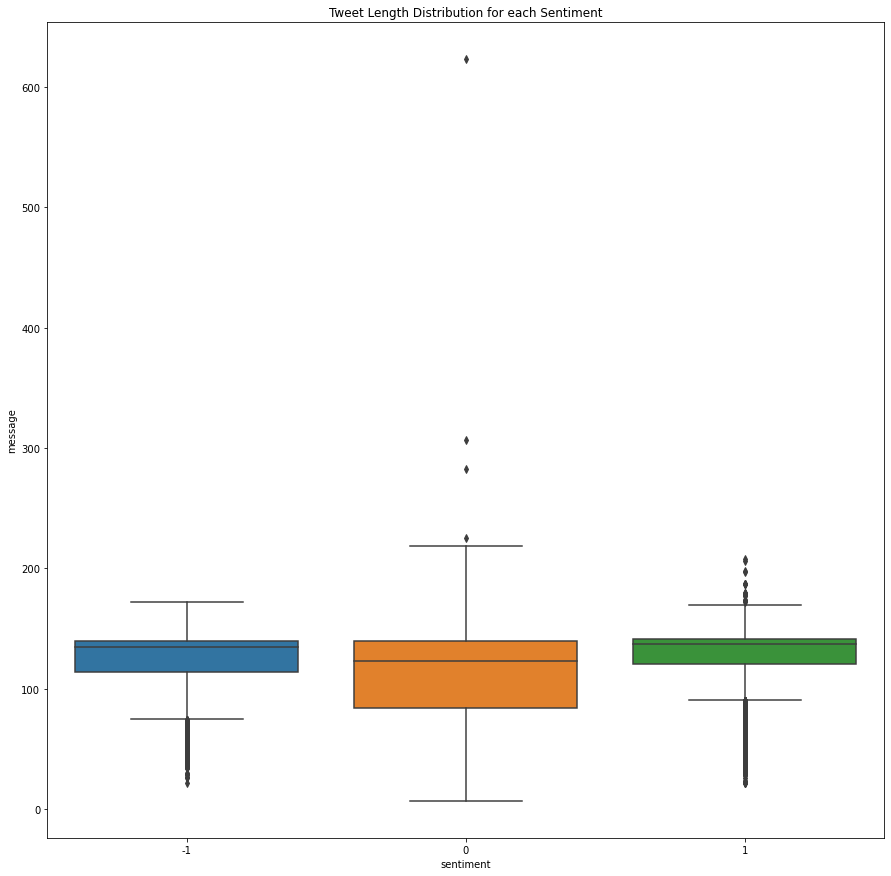

In [20]:
plt.figure(figsize=(15, 15))
sns.boxplot(x="sentiment", y = df["message"].str.len(), data=df)
plt.title("Tweet Length Distribution for each Sentiment")
plt.show()


In [21]:
# We will go over the sampled text as below.
# Every tweets share the common rule starting with @ + airlines' name.
# We can also see there are http formats, emojis, and hashtag

print(df.message[0].split(),'\n')
print(df.message[1].split(),'\n')
print(df.message[100].split(),'\n')
print(df.message[1000].split(),'\n')
#print(df.message[10000].split())

['@tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom'] 

['RT', '@NatGeoChannel:', 'Watch', '#BeforeTheFlood', 'right', 'here,', 'as', '@LeoDiCaprio', 'travels', 'the', 'world', 'to', 'tackle', 'climate', 'change', 'https://t.co/LkDehj3tNn', 'httÃ¢â‚¬Â¦'] 

['RT', '@xeni:', "#Halloween's", 'ok', 'but', 'if', 'you', 'really', 'wanna', 'get', 'scared', 'watch', 'this', 'new', '@NatGeoÃ¢â‚¬â€¹', 'climate', 'change', 'doc', 'with', '@LeoDiCaprio', 'https://t.co/rUFMÃ¢â‚¬Â¦'] 

['RT', '@qz:', 'A', 'new', 'report', 'shows', 'that', 'our', 'efforts', 'to', 'fight', 'global', 'warming', 'are', 'paying', 'off', 'in', 'the', 'biggest', 'way', 'yet', 'https://t.co/fPYZlR98PZ'] 



In [22]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

names = ['global warming', 'climate change']

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

def clean_stopword(d):
    stop_words = stopwords.words('english')
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kysgattu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kysgattu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
df['final_text']= df.message.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0    [tiniebeany, climate, change, interesting, hus...
1    [rt, natgeochannel, watch, beforetheflood, rig...
2    [fabulous, leonardo, dicaprios, film, climate,...
3    [rt, mickfanning, watched, amazing, documentar...
4    [unamshow, awache, kujinga, na, iko, global, w...
Name: final_text, dtype: object

In [24]:
print(" ".join(df.final_text[0]),'\n')
print(" ".join(df.final_text[1]),'\n')
print(" ".join(df.final_text[100]),'\n')
print(" ".join(df.final_text[1000]),'\n')
#print(" ".join(df.final_text[10000]))

tiniebeany climate change interesting hustle global warming planet stopped warming yes suv boom 

rt natgeochannel watch beforetheflood right leodicaprio travels world tackle climate change httpstcolkdehjtnn htt 

rt xeni halloweens ok really wan na get scared watch new natgeo climate change doc leodicaprio httpstcorufm 

rt qz new report shows efforts fight global warming paying biggest way yet httpstcofpyzlrpz 



In [25]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(df.final_text[0]))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kysgattu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.103, 'neu': 0.432, 'pos': 0.465, 'compound': 0.6908}

In [26]:
len(df)

34667

In [27]:
texts = ' '
for i in range(5):
    print(df.final_text[i])

['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']
['rt', 'natgeochannel', 'watch', 'beforetheflood', 'right', 'leodicaprio', 'travels', 'world', 'tackle', 'climate', 'change', 'httpstcolkdehjtnn', 'htt']
['fabulous', 'leonardo', 'dicaprios', 'film', 'climate', 'change', 'brilliant', 'watch', 'httpstcorvbrmxjw', 'via', 'youtube']
['rt', 'mickfanning', 'watched', 'amazing', 'documentary', 'leonardodicaprio', 'climate', 'change', 'think', 'httpstcoknstekim']
['unamshow', 'awache', 'kujinga', 'na', 'iko', 'global', 'warming', 'httpstcomhiflumx']


In [28]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

In [29]:
texts = [" ".join(df.final_text[i]) for i in range(len(df))]

print(df.message[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {df.sentiment[0]}', '\n')

print(df.message[1])
print(texts[1])
print(vader.polarity_scores(texts[1]), f'--> Actual Classification: {df.sentiment[1]}', '\n')

print(df.message[10])
print(texts[10])
print(vader.polarity_scores(texts[10]), f'--> Actual Classification: {df.sentiment[10]}', '\n')

print(df.message[100])
print(texts[100])
print(vader.polarity_scores(texts[100]), f'--> Actual Classification: {df.sentiment[100]}', '\n')

print(df.message[1000])
print(texts[1000])
print(vader.polarity_scores(texts[1000]), f'--> Actual Classification: {df.sentiment[1000]}', '\n')

#print(df.message[10000])
#print(texts[10000])
#print(vader.polarity_scores(texts[10000]), f'--> Actual Classification: {df.sentiment[10000]}')


@tiniebeany climate change is an interesting hustle as it was global warming but the planet stopped warming for 15 yes while the suv boom
tiniebeany climate change interesting hustle global warming planet stopped warming yes suv boom
{'neg': 0.103, 'neu': 0.432, 'pos': 0.465, 'compound': 0.6908} --> Actual Classification: -1 

RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world to tackle climate change https://t.co/LkDehj3tNn httÃ¢â‚¬Â¦
rt natgeochannel watch beforetheflood right leodicaprio travels world tackle climate change httpstcolkdehjtnn htt
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: 1 

Now's the time: we need a strong #FTT that works for those hardest hit by climate change and poverty!
nows time need strong ftt works hardest hit climate change poverty
{'neg': 0.212, 'neu': 0.577, 'pos': 0.212, 'compound': 0.0} --> Actual Classification: 1 

RT @xeni: #Halloween's ok but if you really wanna get scared watc

In [30]:
# preprocessing before drawing wordcloud separating the sentiment.

pro = df[df.sentiment == 1].message.apply(clean_text).apply(clean_stopword).apply(tokenize)
pro = [" ".join(pro.values[i]) for i in range(len(pro))]
pro = [" ".join(pro)][0]

anti = df[df.sentiment == -1].message.apply(clean_text).apply(clean_stopword).apply(tokenize)
anti = [" ".join(anti.values[i]) for i in range(len(anti))]
anti = [" ".join(anti)][0]

neutral = df[df.sentiment == 0].message.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

#news = df[df.sentiment == 2].message.apply(clean_text).apply(clean_stopword).apply(tokenize)
#news = [" ".join(news.values[i]) for i in range(len(news))]
#news = [" ".join(news)][0]

print(len(pro), len(anti), len(neutral))

2190971 367261 637868


In [31]:
from wordcloud import WordCloud

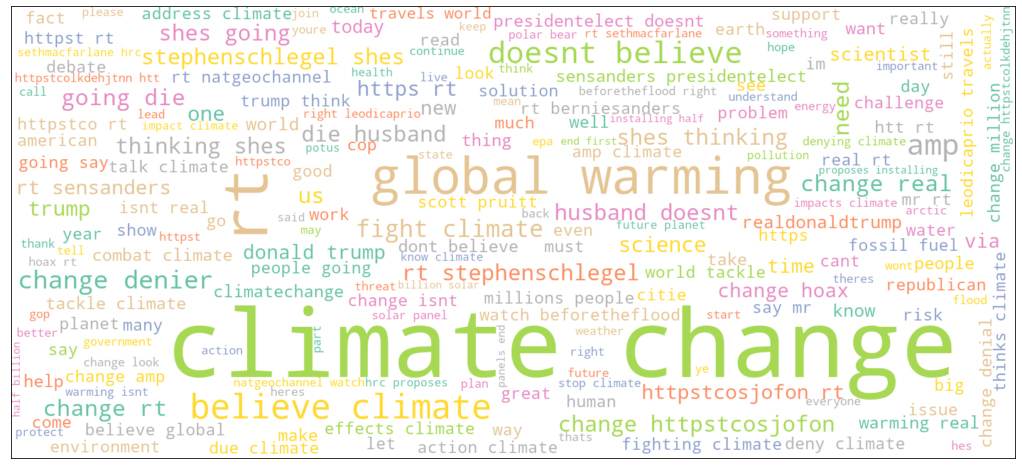

In [32]:
plt.figure(figsize=(18,15))
wc_pro = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(pro)

plt.imshow(wc_pro,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

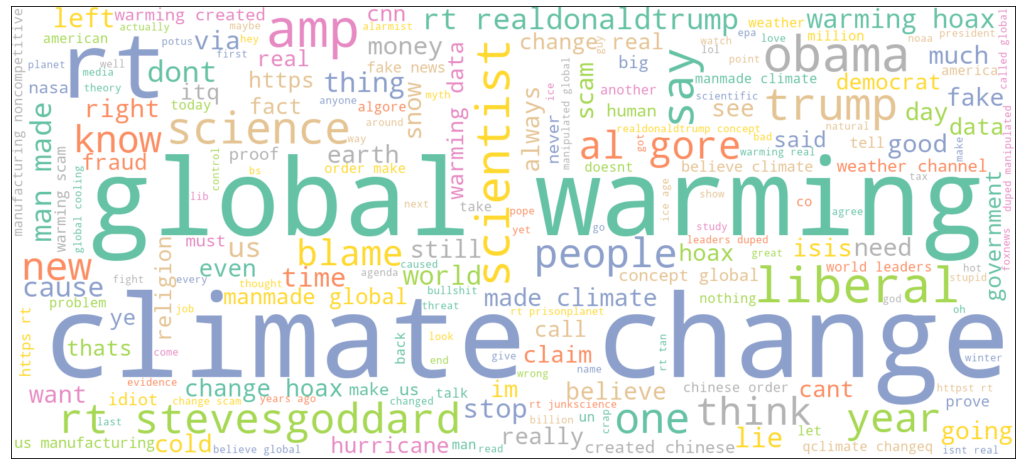

In [33]:
plt.figure(figsize=(18,15))
wc_anti = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(anti)

plt.imshow(wc_anti,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

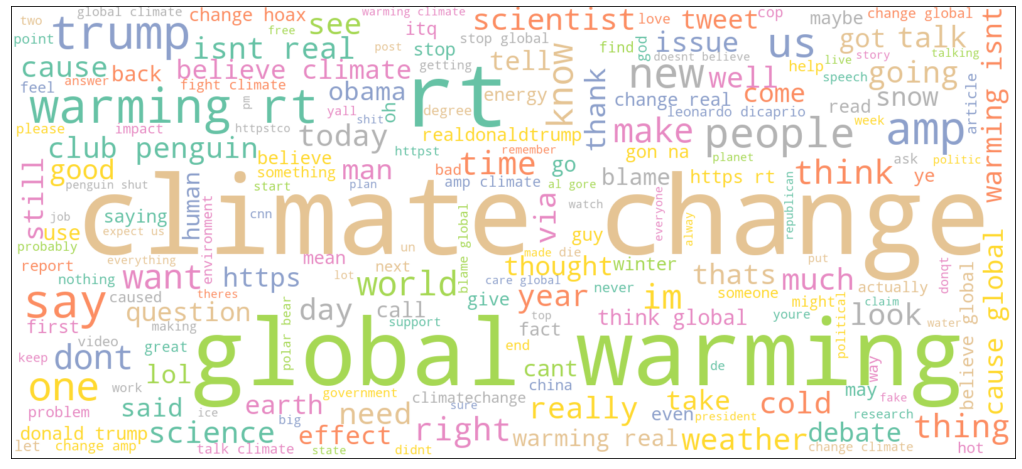

In [34]:
plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.naive_bayes import ComplementNB as CNB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC as SVC
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.metrics import *

import warnings
warnings.filterwarnings('ignore')

In [36]:
df2.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,0,Unamshow awache kujinga na iko global warming ...,793125429418815489


In [37]:
X = df2["message"]
y = df2["sentiment"]
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X, y, test_size=0.2, random_state=42)


In [38]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(X_train_ml)


<27733x52139 sparse matrix of type '<class 'numpy.float64'>'
	with 491082 stored elements in Compressed Sparse Row format>

In [40]:
#Logistic Regression
logreg_model = LGR(class_weight="balanced", max_iter=1000)
logreg_model.fit(tfidf.transform(X_train_ml), y_train_ml)
logreg_preds = logreg_model.predict(tfidf.transform(X_test_ml))



k_values = []
train_scores = []
test_scores = []
for k in range (1,31):
    temp_knn_k = KNN(n_neighbors=k)
    temp_knn_k.fit(tfidf.transform(X_train_ml), y_train_ml)
    y_pred_temp_knn = temp_knn_k.predict(tfidf.transform(X_test_ml))
    train_score=temp_knn_k.score(tfidf.transform(X_train_ml),y_train_ml)
    test_score=temp_knn_k.score(tfidf.transform(X_test_ml),y_test_ml)
    train_scores.append(train_score)
    test_scores.append(test_score)
    k_values.append(k)
print(k_values)
print(train_scores)
print(test_scores)

plt.plot(k_values,train_scores, color='red',label='Training Score')
plt.plot(k_values,test_scores, color='blue',label='Testing Score')

plt.legend(loc="best")
plt.xlabel('K values')
plt.ylabel('Scores')

In [41]:
#K-Nearest Neighbour with euclidean distance
knn_model = KNN(n_neighbors=15)
knn_model.fit(tfidf.transform(X_train_ml), y_train_ml)
knn_preds = knn_model.predict(tfidf.transform(X_test_ml))


In [42]:
#Multinomial Naive Bayes
#mnb_model = MNB()
#mnb_model.fit(tfidf.transform(X_train_ml), y_train_ml)
#mnb_preds = mnb_model.predict(tfidf.transform(X_test_ml))


In [43]:
#Complement Naive Bayes
cnb_model = CNB()
cnb_model.fit(tfidf.transform(X_train_ml), y_train_ml)
cnb_preds = cnb_model.predict(tfidf.transform(X_test_ml))


#defining the kernels defined in scikit-learn
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
#creating temporary models with all available kernels and analysing train and test scores
print(' Kernel ' + ' Train Score ' + ' Test Score')
for k in kernels:
    temp_svm = SVC(kernel = k)
    temp_svm.fit(tfidf.transform(X_train_ml), y_train_ml)
    temp_y_pred = temp_svm.predict(tfidf.transform(X_test_ml))
    train_score=temp_svm.score(tfidf.transform(X_train_ml), y_train_ml)
    test_score=temp_svm.score(tfidf.transform(X_test_ml),y_test_ml)
    print(k,train_score,test_score)




In [44]:
#Random Forest
rf_model= RFC(n_estimators = 100, criterion = 'gini', max_features = 'log2')
rf_model.fit(tfidf.transform(X_train_ml), y_train_ml)
rf_preds = rf_model.predict(tfidf.transform(X_test_ml))


# CNN

In [45]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional,Embedding, Dropout, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [46]:
from keras.metrics import Precision, Recall

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['final_text'][0],'\n')
X, tokenizer = tokenize_pad_sequences(df['final_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 ['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom'] 

After Tokenization & Padding 
 [   1    2  533    4    5   51  995    5  180 4871 3341    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [49]:
y = pd.get_dummies(df.sentiment)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

print('Train:         ', X_train.shape, y_train.shape)
print('Validation Set:', X_valid.shape, y_valid.shape)
print('Test Set:      ', X_test.shape, y_test.shape)

Train:          (19413, 100) (19413, 3)
Validation Set: (8320, 100) (8320, 3)
Test Set:       (6934, 100) (6934, 3)


In [50]:
X_train

array([[   3,   53,   17, ...,    0,    0,    0],
       [1088,  207, 4828, ...,    0,    0,    0],
       [2566,    4,    5, ...,    0,    0,    0],
       ...,
       [   3,    1,    2, ...,    0,    0,    0],
       [   3, 1558, 2284, ...,    0,    0,    0],
       [   3, 2636, 2204, ...,    0,    0,    0]], dtype=int32)

In [51]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
#plot_model(model, show_shapes = True)

Metal device set to: Apple M1 Pro


2022-04-24 14:24:45.283599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-24 14:24:45.283684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [53]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50


2022-04-24 14:24:45.701981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-24 14:24:47.082246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:24:47.369722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:24:47.380023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:24:47.560779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:24:47.576279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


304/304 [==============================] - ETA: 0s - loss: 0.7344 - accuracy: 0.6936 - precision: 0.7580 - recall: 0.5815

2022-04-24 14:25:04.840221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:25:04.956230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-24 14:25:04.964057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


304/304 [==============================] - 22s 65ms/step - loss: 0.7344 - accuracy: 0.6936 - precision: 0.7580 - recall: 0.5815 - val_loss: 0.6262 - val_accuracy: 0.7227 - val_precision: 0.8221 - val_recall: 0.6109
Epoch 2/50
304/304 [==============================] - 19s 61ms/step - loss: 0.5437 - accuracy: 0.7757 - precision: 0.8344 - recall: 0.6963 - val_loss: 0.5670 - val_accuracy: 0.7730 - val_precision: 0.8096 - val_recall: 0.7254
Epoch 3/50
304/304 [==============================] - 19s 61ms/step - loss: 0.4402 - accuracy: 0.8251 - precision: 0.8519 - recall: 0.7893 - val_loss: 0.5721 - val_accuracy: 0.7671 - val_precision: 0.7933 - val_recall: 0.7400
Epoch 4/50
304/304 [==============================] - 19s 62ms/step - loss: 0.3601 - accuracy: 0.8594 - precision: 0.8802 - recall: 0.8364 - val_loss: 0.6081 - val_accuracy: 0.7625 - val_precision: 0.7848 - val_recall: 0.7397
Epoch 5/50
304/304 [==============================] - 20s 65ms/step - loss: 0.2898 - accuracy: 0.8914 - pre

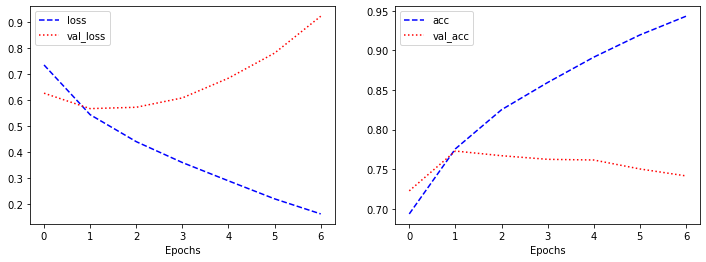

In [54]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [56]:
# Evaluate model on the test set
lstm_loss, lstm_accuracy, lstm_precision, lstm_recall = model.evaluate(X_test, y_test, verbose=0)
lstm_f1_score = 2 * (lstm_precision * lstm_recall) / (lstm_precision + lstm_recall)
# Print metrics

In [57]:
print('Accuracy  : {:.4f}'.format(lstm_accuracy))
print('Precision  : {:.4f}'.format(lstm_precision))
print('Recall  : {:.4f}'.format(lstm_recall))
print('F1-Score  : {:.4f}'.format(lstm_f1_score))

Accuracy  : 0.7380
Precision  : 0.7469
Recall  : 0.7276
F1-Score  : 0.7371
